This example is available as a jupyter notebook in colab [here](https://colab.research.google.com/github/SimiPixel/x_xy_v2/blob/main/docs/notebooks/getting_started.ipynb).

In [ ]:
# install dependencies in colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
    
if IN_COLAB:
    %pip install git+https://github.com/SimiPixel/x_xy_v2.git
    %pip install pyqt6

In [41]:
import x_xy

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

import mediapy as media
import vispy
vispy.use("pyqt6")

Systems are defined with the following xml syntax.

In [7]:
xml_str = """
<x_xy model="double_pendulum">
    <options gravity="0 0 9.81" dt="0.01"/>
    <worldbody>
        <body name="upper" euler="0 90 0" joint="ry" damping="2">
            <geom type="box" mass="10" pos="0.5 0 0" dim="1 0.25 0.2"/>
            <body name="lower" pos="1 0 0" joint="ry" damping="2">
                <geom type="box" mass="10" pos="0.5 0 0" dim="1 0.25 0.2"/>
            </body>
        </body>
    </worldbody>
</x_xy>
"""

With this xml description of the system, we are ready to load the system using `load_sys_from_str`. We can also save this to a text-file `double_pendulum.xml` and load with `load_sys_from_xml`.

In [8]:
sys = x_xy.load_sys_from_str(xml_str)

In [9]:
sys.model_name

'double_pendulum'

System objects have many attributes. You may refer to the API documentation for more details.

In [10]:
sys.link_names

['upper', 'lower']

## Dynamical Simulation

Let's start with the most obvious. A physical simulation. We refer to it as "dynamical simulation", in contrast to what we do a little later which is a purely kinematic simulation.

First, we have to create the dynamical state of the system. It is defined by the all degrees of freedom in the system and their velocities. Here, we have two revolute joints (one degree of freedom). Thus, the minimal coordinates vector $q$ and minimal velocity vector $q'$ has two dimensions.

In [11]:
state = x_xy.State.create(sys)

In [12]:
state.q

Array([0., 0.], dtype=float32)

In [13]:
state.qd

Array([0., 0.], dtype=float32)

In [14]:
next_state = x_xy.step(sys, state)

Massive speedups if we use `jax.jit` to jit-compile the function.

In [15]:
%timeit x_xy.step(sys, state)

340 ms ± 11.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%timeit jax.jit(x_xy.step)(sys, state)

89.2 µs ± 41.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's unroll the dynamics for multiple timesteps.

In [17]:
T = 10.0
xs = []
for _ in range(int(T / sys.dt)):
    state = jax.jit(x_xy.step)(sys, state)
    xs.append(state.x)

Next, let's render the frames and create an animation.

In [18]:
frames = x_xy.render_frames(sys, xs)

Rendering frames..: 100%|██████████| 1000/1000 [00:03<00:00, 272.26it/s]


In [19]:
def show_video(frames: list[np.ndarray], dt: float):
    assert dt == 0.01
    # frames are at 100 Hz, but let's create an animation at 25Hz
    media.show_video([frames[i][..., :3] for i in range(0, len(frames), 4)], fps=25)

show_video(frames, sys.dt)

Hmm, pretty boring. Let's get the pendulum into an configuration with some potential energy.

All we have to change is the initial state `state.q`.

In [20]:
state = x_xy.State.create(sys, q=jnp.array([jnp.pi / 2, 0]))

In [21]:
T = 10.0
xs = []
for _ in range(int(T / sys.dt)):
    state = jax.jit(x_xy.step)(sys, state)
    xs.append(state.x)
    
frames = x_xy.render_frames(sys, xs)
show_video(frames, sys.dt)

Rendering frames..: 100%|██████████| 1000/1000 [00:03<00:00, 276.10it/s]


That's more like it!

Next, we will take a look at "kinematic simulation".

## Kinematic Simulation

Let's start with why you would want this. 

Imagine we want to learn a filter that estimates some quantity of interest from some sensor input. 

Then, we could try to create many random motions, record the measured sensor input, and the ground truth quantity of interest target values. 

This is then used as training data for a Machine Learning model.

The general interface to kinematic simulation is via `x_xy.build_generator`.

This function creates a function (of type `Generator`) that maps a PRNG seed to, e.g., `X, y` data.

In [31]:
gen = x_xy.build_generator(sys, x_xy.RCMG_Config(T=10.0, t_max=1.5))
seed = 1
_, xs = gen(jax.random.PRNGKey(seed))

In [32]:
# right now `xs` is a batched `Transform` object
# so convert to a list of unbatched `Transform` object which is what `render_frames` expects.
xs_list = [xs[i] for i in range(xs.shape())]

In [28]:
frames = x_xy.render_frames(sys, xs_list)

Rendering frames..: 100%|██████████| 1000/1000 [00:03<00:00, 286.03it/s]


This is now completely random, but unphysical motion. It's only kinematics, but that is okay for creating training data.

In [29]:
show_video(frames, sys.dt)

## `X, y` Training data / Attaching sensors

We are interested in simulating IMU data as input `X`, and estimating quaternions as target `y`.

We can easily simulate an IMU with only the trajectory of maximal coordinates `xs`.

Suppose, we want to simulate an IMU right that is placed on the `lower` segment and right at the revolute joint.

This is exactly where the coordinate system of the `lower` segment is placed.

Right now the `xs` trajectory contains both coordinate sytems of `upper` and `lower`.

In [33]:
# (n_timesteps, n_links, 3)
xs.pos.shape

(1000, 2, 3)

In [34]:
# (n_timesteps, n_links, 4)
xs.rot.shape

(1000, 2, 4)

From the axis with length two, the 0th entry is for `upper` and the 1st entry is for `lower`.

In [38]:
sys.name_to_idx("upper")

0

In [37]:
sys.name_to_idx("lower")

1

In [39]:
xs_lower = xs.take(1, axis=1)

In [40]:
imu_lower = x_xy.imu(xs_lower, sys.gravity, sys.dt)

In [42]:
imu_lower.keys()

dict_keys(['acc', 'gyr'])

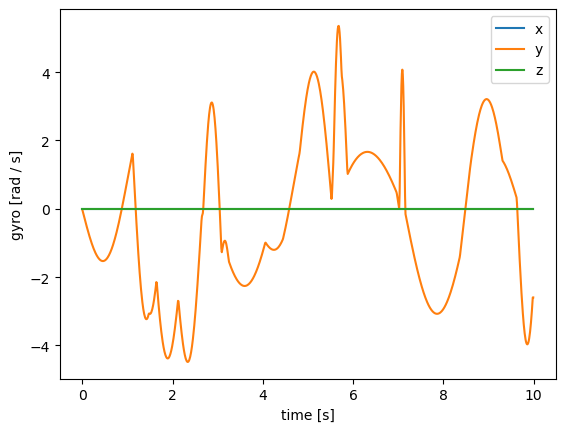

In [46]:
plt.grid()
plt.plot(np.arange(0, 10.0, step=sys.dt), imu_lower["gyr"], label=["x", "y", "z"])
plt.ylabel("gyro [rad / s]")
plt.xlabel("time [s]")
plt.legend()
plt.show()

As you can see it's a two-dimensional problem, which is why only one (`y`) is non-zero.

Let's consider a larger kinematic chain in free 3D space.

In [48]:
xml_str = """
<x_xy model="three_segment_kinematic_chain">
    <options gravity="0 0 9.81" dt="0.01"/>
    <worldbody>
        <body name="seg2" joint="free">
            <geom type="box" mass="0.1" pos="0.5 0 0" dim="1 0.25 0.2"/>
            <body name="seg1" joint="ry">
                <geom type="box" mass="0.1" pos="-0.5 0 0" dim="-1 0.25 0.2"/>
                <body name="imu1" joint="frozen" pos="-0.5 0 0.125">
                    <geom type="box" mass="0.05" dim="0.2 0.2 0.05" color="orange"/>
                </body>
            </body>
            <body name="seg3" joint="rz" pos="1 0 0">
                <geom type="box" mass="0.1" pos="0.5 0 0" dim="1 0.25 0.2"/>
                <body name="imu2" joint="frozen" pos="0.5 0 -0.125">
                    <geom type="box" mass="0.05" dim="0.2 0.2 0.05" color="orange"/>
                </body>
            </body>
        </body>
    </worldbody>
</x_xy>
"""

sys = x_xy.load_sys_from_str(xml_str)

gen = x_xy.build_generator(sys, x_xy.RCMG_Config(T=10.0, t_max=1.5))
seed = 1
_, xs = gen(jax.random.PRNGKey(seed))
xs_list = [xs[i] for i in range(xs.shape())]
frames = x_xy.render_frames(sys, xs_list)
show_video(frames, sys.dt)


Rendering frames..: 100%|██████████| 1000/1000 [00:04<00:00, 223.44it/s]


We can modify the `build_generator` with a custom `finalize_fn` which determines what output the generator generates.

The two orange boxes on segment 1 and segment 3 are modelling our two IMUs. This will be the network's input `X` data.

As target we will try to estimate both relative orientations as `y` data.

In [49]:
def finalize_fn(key: jax.Array, q: jax.Array, xs: x_xy.Transform, sys: x_xy.System):
    xs_by_name = lambda name: xs.take(sys.name_to_idx(name), axis=1)
    X = {
        "seg1": x_xy.imu(xs_by_name("imu1"), sys.gravity, sys.dt),
        "seg3": x_xy.imu(xs_by_name("imu2"), sys.gravity, sys.dt),
    }
    
    xs_seg1 = xs_by_name("seg1")
    xs_seg2 = xs_by_name("seg2")
    xs_seg3 = xs_by_name("seg3")

    # all `xs` transforms are to be interpreted as "from epsilon to segment"
    xs_from_seg2_to_seg1 = x_xy.transform_mul(xs_seg1, x_xy.transform_inv(xs_seg2))
    xs_from_seg3_to_seg2 = x_xy.transform_mul(xs_seg2, x_xy.transform_inv(xs_seg3))

    y = {
        # we only estimate the orientation, so extract the quaternion from the transform (transform.rot)
        "seg2": xs_from_seg2_to_seg1.rot,
        "seg3": xs_from_seg3_to_seg2.rot
    }
    return X, y


gen = x_xy.build_generator(sys, x_xy.RCMG_Config(T=10.0, t_max=1.5), finalize_fn=finalize_fn)
seed = 1
X, y = gen(jax.random.PRNGKey(seed))

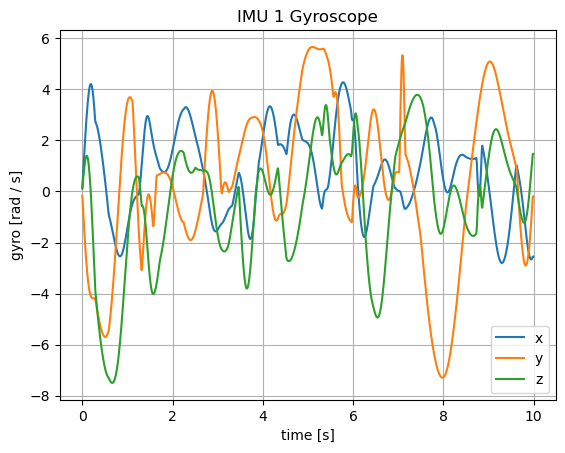

In [54]:
plt.grid()
plt.plot(np.arange(0, 10.0, step=sys.dt), X["seg1"]["gyr"], label=["x", "y", "z"])
plt.ylabel("gyro [rad / s]")
plt.xlabel("time [s]")
plt.title("IMU 1 Gyroscope")
plt.legend()
plt.show()


Now, the IMU is non-zero in all three `x/y/z` components.

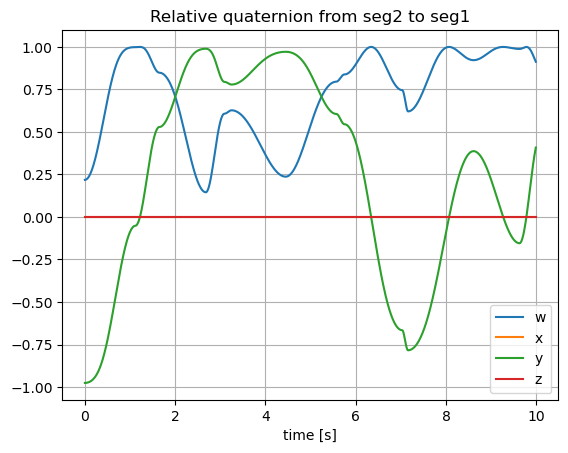

In [56]:
plt.grid()
plt.plot(np.arange(0, 10.0, step=sys.dt), y["seg2"], label=["w", "x", "y", "z"])
plt.xlabel("time [s]")
plt.title("Relative quaternion from seg2 to seg1")
plt.legend()
plt.show()


Note how the relative quaternion is only around the y-axis. Can you see why? (Hint: Check the defining `xml_str`.)